In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from src.problem_loaders.tsp_loader import TSPLoader
from src.algorithms.ga_tsp import GeneticAltorithmTSP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_tsp import AntTSP

# Compare Algorithms for different Problem Instance sizes

In [68]:
PROBLEM_INSTANCE_NAMES = ['GR17', 'FRI26', 'DANTZIG42', 'ATT48']

ga_stats_df_list = []
as_stats_df_list = []
optimal_fitness_dict = {}
worst_fitness_dict = {}
for problem_instance_name in PROBLEM_INSTANCE_NAMES:
    tsp_loader = TSPLoader(problem_instance_name)
    problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
    optimal_fitness_dict[problem_instance_name] = optimal_fitness
    # run ga and save output
    ga = GeneticAltorithmTSP(problem_instance, population_size=100, max_generations=700, mutation_rate=0.5, elitism_rate=0.2)
    ga.run()
    ga_df = ga.fitness_df()
    ga_df['name'] = problem_instance_name
    ga_stats_df_list.append(ga_df)
    # run ant system and save output
    ant_system = AntSystem(AntTSP, problem_instance, number_of_ants=150, time=700, evaporation_coefficient=0.2)
    ant_system.run()
    as_df = ant_system.fitness_df()
    as_df['name'] = problem_instance_name
    as_stats_df_list.append(as_df)
    # store worst fitness all generations and algorithms
    max_fitness = ga_df.fitness.max()
    if as_df.fitness.max() > max_fitness:
        max_fitness = as_df.fitness.max()
    worst_fitness_dict[problem_instance_name] = max_fitness
ga_stats_df = pd.concat(ga_stats_df_list)
as_stats_df = pd.concat(as_stats_df_list)

Time Point: 100%|██████████| 700/700 [02:21<00:00,  4.95it/s]


In [69]:
ga_stats_df_scaled_list = []
for df in ga_stats_df_list:
    df_scaled = df.copy()
    name = df_scaled.name.values[0]
    df_scaled.fitness = df_scaled.fitness.apply(lambda x: (x - optimal_fitness_dict[name]) / (worst_fitness_dict[name] - optimal_fitness_dict[name]))
    ga_stats_df_scaled_list.append(df_scaled)
ga_stats_df_scaled = pd.concat(ga_stats_df_scaled_list)

as_stats_df_scaled_list = []
for df in as_stats_df_list:
    df_scaled = df.copy()
    name = df_scaled.name.values[0]
    df_scaled.fitness = df_scaled.fitness.apply(lambda x: (x - optimal_fitness_dict[name]) / (worst_fitness_dict[name] - optimal_fitness_dict[name]))
    as_stats_df_scaled_list.append(df_scaled)
as_stats_df_scaled = pd.concat(as_stats_df_scaled_list)


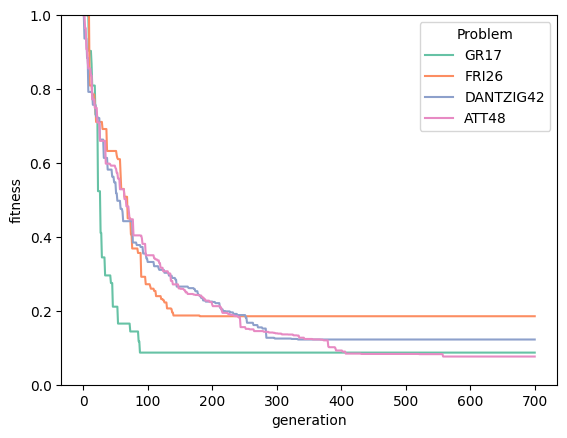

In [74]:
chart = sns.lineplot(data=ga_stats_df_scaled, x='generation', y='fitness', hue='name', palette=sns.color_palette('Set2')[:4])
plt.legend(title='Problem')
plt.ylim(0,1)
plt.savefig('ga_by_problem.png')

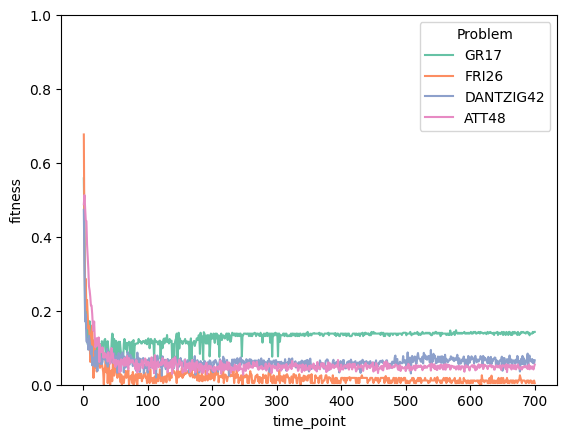

In [75]:
chart = sns.lineplot(data=as_stats_df_scaled, x='time_point', y='fitness', hue='name', palette=sns.color_palette('Set2')[:4])
plt.legend(title='Problem')
plt.ylim(0,1)
plt.savefig('ant_system_by_problem.png')

# Study Parameters for Genetic Algorithm

Generation: 100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


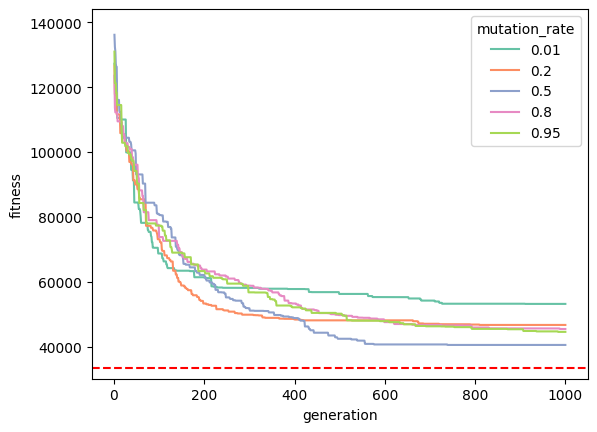

In [84]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
mutation_rates = [0.01, 0.2, 0.5, 0.8, 0.95]
stats_df_list = []
for mutation_rate in mutation_rates:
    ga = GeneticAltorithmTSP(problem_instance, population_size=200, max_generations=1000, two_children_per_crossover=True, elitism_rate=0.1, mutation_rate=mutation_rate)
    ga.run()
    stats_df = ga.fitness_df()
    stats_df['mutation_rate'] = mutation_rate
    stats_df_list.append(stats_df)
stats_df_mutation_rate = pd.concat(stats_df_list)
chart = sns.lineplot(data=stats_df_mutation_rate.reset_index(), x='generation', y='fitness', hue='mutation_rate', palette=sns.color_palette('Set2')[:5])
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.savefig('tsp_ga_by_mutation_rate.png')

Generation: 100%|██████████| 1000/1000 [00:29<00:00, 33.45it/s]


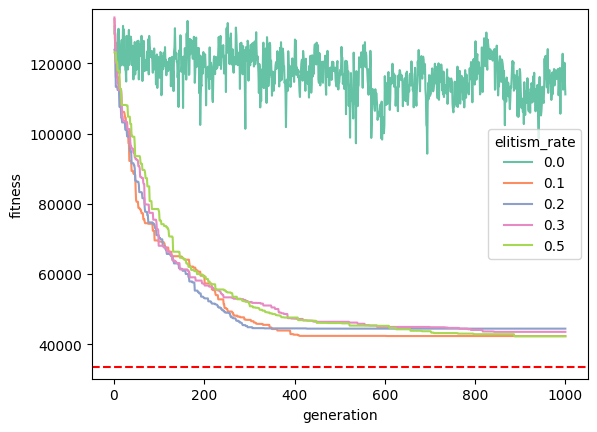

In [87]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
elitism_rates = [0.0, 0.1, 0.2, 0.3, 0.5]
stats_df_list = []
for elitism_rate in elitism_rates:
    ga = GeneticAltorithmTSP(problem_instance, population_size=250, max_generations=1000, two_children_per_crossover=False, elitism_rate=elitism_rate, mutation_rate=0.5)
    ga.run()
    stats_df = ga.fitness_df()
    stats_df['elitism_rate'] = elitism_rate
    stats_df_list.append(stats_df)
stats_df_elitism_rate = pd.concat(stats_df_list)
chart = sns.lineplot(data=stats_df_elitism_rate.reset_index(), x='generation', y='fitness', hue='elitism_rate', palette=sns.color_palette('Set2')[:5])
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.savefig('tsp_ga_by_elitism_rate.png')

In [3]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
ga_per_trail = []
def objective(trial):
    kwargs = {
        'population_size': trial.suggest_int('population_size', 10, 1000),
        'max_generations': 1500,
        'mutation_rate': trial.suggest_float('mutation_rate', 0.001, 1.0),
        'elitism_rate': trial.suggest_float('elitism_rate', 0.0, 0.5),
        'two_children_per_crossover': trial.suggest_categorical('two_children_per_crossover', [True, False])
    }
    ga = GeneticAltorithmTSP(problem_instance, **kwargs)
    ga.run()
    ga_per_trail.append(ga)
    return min(ga.best_fitness_in_generation)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2022-11-27 12:41:53,536] A new study created in memory with name: no-name-9fe17d11-f624-4cd3-9221-80129463346e
Generation: 100%|██████████| 1500/1500 [00:40<00:00, 36.75it/s]
[I 2022-11-27 12:42:34,378] Trial 0 finished with value: 101946.0 and parameters: {'population_size': 79, 'mutation_rate': 0.8599090338949269, 'elitism_rate': 0.008085279723838878, 'two_children_per_crossover': True}. Best is trial 0 with value: 101946.0.
Generation: 100%|██████████| 1500/1500 [01:43<00:00, 14.47it/s]
[I 2022-11-27 12:44:19,004] Trial 1 finished with value: 38623.0 and parameters: {'population_size': 544, 'mutation_rate': 0.7722002931723848, 'elitism_rate': 0.4934627799654361, 'two_children_per_crossover': False}. Best is trial 1 with value: 38623.0.
Generation: 100%|██████████| 1500/1500 [01:09<00:00, 21.52it/s]
[I 2022-11-27 12:45:28,905] Trial 2 finished with value: 40188.0 and parameters: {'population_size': 255, 'mutation_rate': 0.7329530628530303, 'elitism_rate': 0.2406614297311827, 'two_

Trail params: {'population_size': 79, 'mutation_rate': 0.8599090338949269, 'elitism_rate': 0.008085279723838878, 'two_children_per_crossover': True}


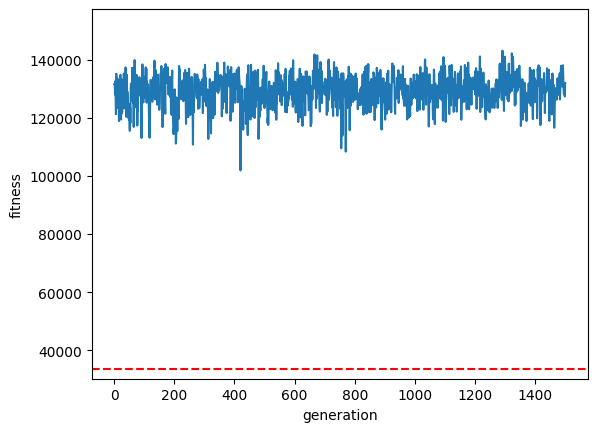

Trail params: {'population_size': 544, 'mutation_rate': 0.7722002931723848, 'elitism_rate': 0.4934627799654361, 'two_children_per_crossover': False}


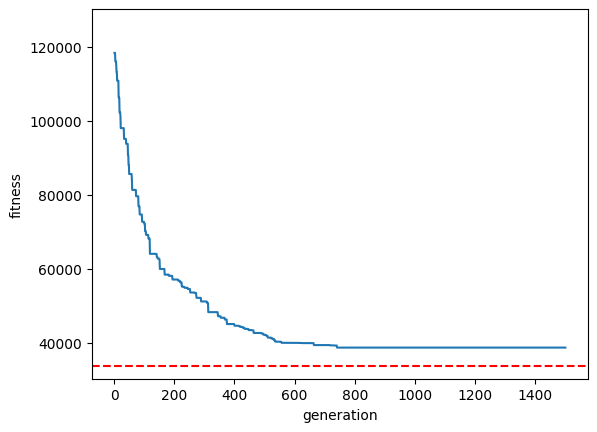

Trail params: {'population_size': 255, 'mutation_rate': 0.7329530628530303, 'elitism_rate': 0.2406614297311827, 'two_children_per_crossover': False}


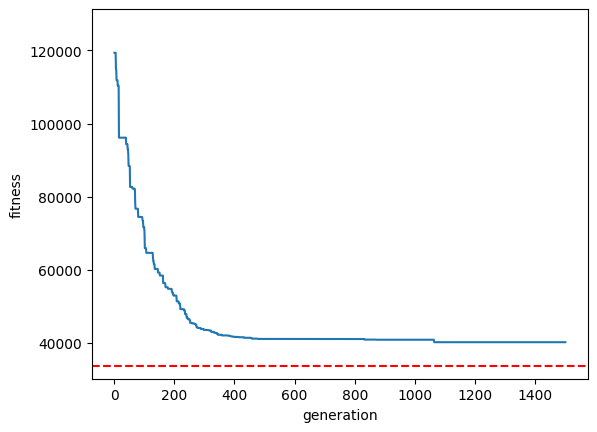

Trail params: {'population_size': 339, 'mutation_rate': 0.7798389727534987, 'elitism_rate': 0.1713615560304913, 'two_children_per_crossover': True}


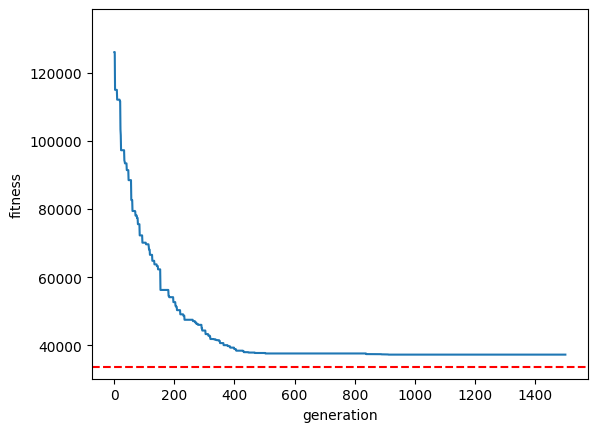

Trail params: {'population_size': 364, 'mutation_rate': 0.7570638963961243, 'elitism_rate': 0.3579061219728433, 'two_children_per_crossover': True}


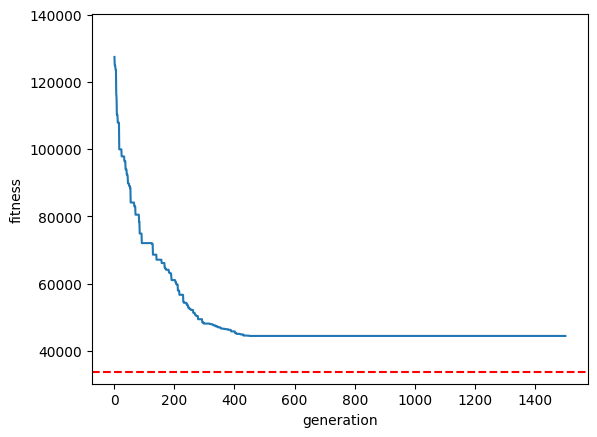

Trail params: {'population_size': 129, 'mutation_rate': 0.6123366721650093, 'elitism_rate': 0.47230197988440165, 'two_children_per_crossover': False}


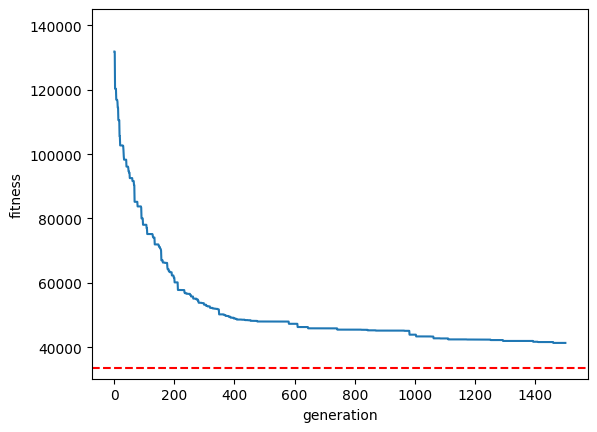

Trail params: {'population_size': 599, 'mutation_rate': 0.4090436535209574, 'elitism_rate': 0.20247879706069022, 'two_children_per_crossover': False}


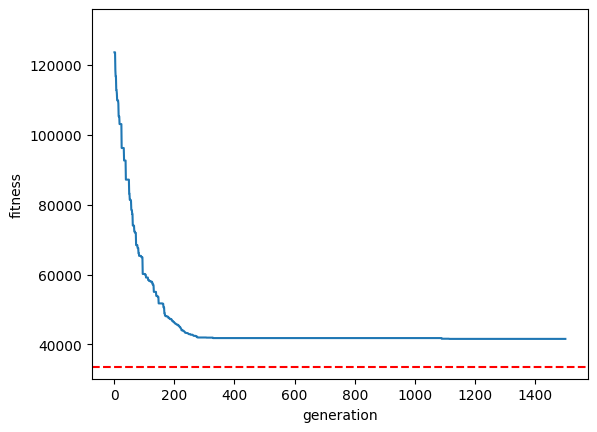

Trail params: {'population_size': 499, 'mutation_rate': 0.6258539716687156, 'elitism_rate': 0.21278623728091967, 'two_children_per_crossover': True}


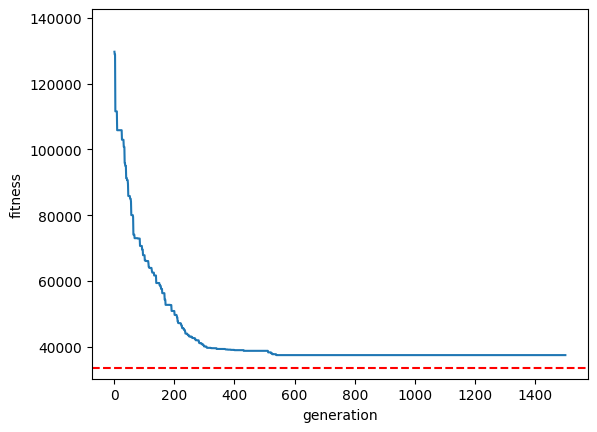

Trail params: {'population_size': 703, 'mutation_rate': 0.20673449716691034, 'elitism_rate': 0.09326301326417291, 'two_children_per_crossover': False}


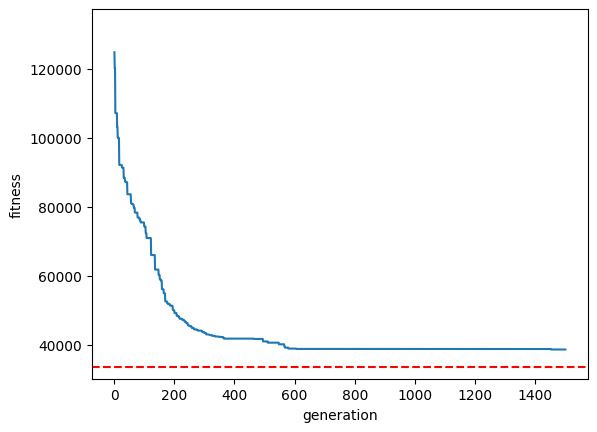

Trail params: {'population_size': 549, 'mutation_rate': 0.5885061230848601, 'elitism_rate': 0.3521368614150874, 'two_children_per_crossover': True}


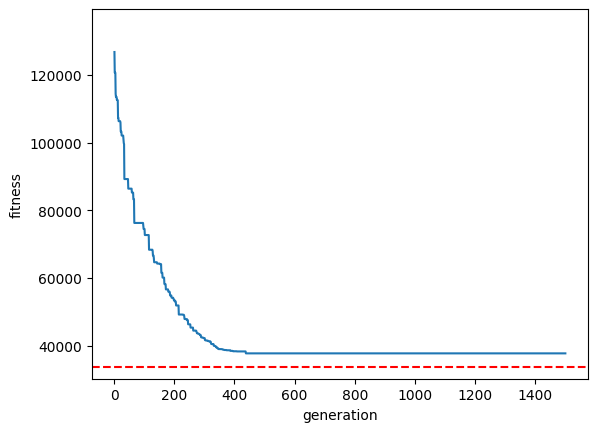

Trail params: {'population_size': 931, 'mutation_rate': 0.9794382886785707, 'elitism_rate': 0.12846430420499108, 'two_children_per_crossover': True}


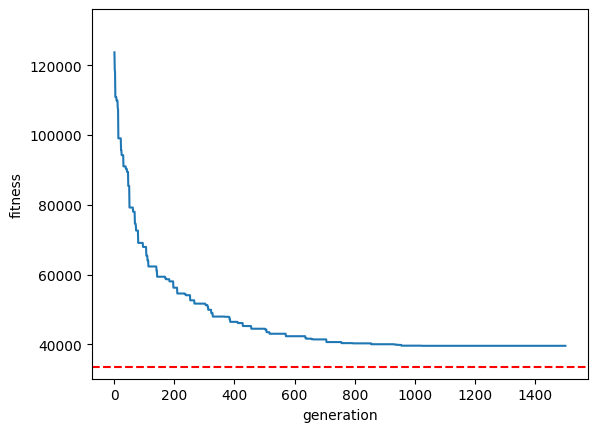

Trail params: {'population_size': 380, 'mutation_rate': 0.38696525096769957, 'elitism_rate': 0.16330719945244554, 'two_children_per_crossover': True}


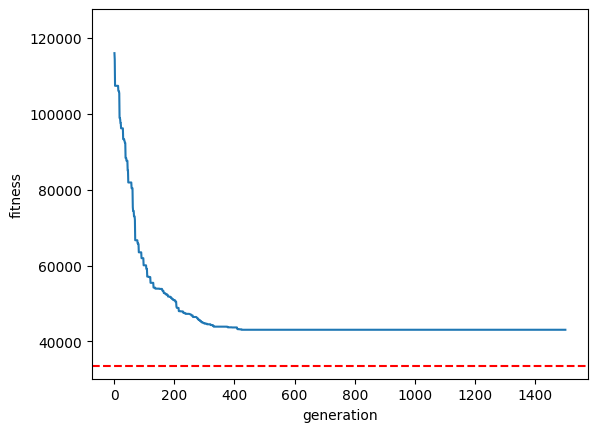

Trail params: {'population_size': 774, 'mutation_rate': 0.011758264834792587, 'elitism_rate': 0.2861767832511216, 'two_children_per_crossover': True}


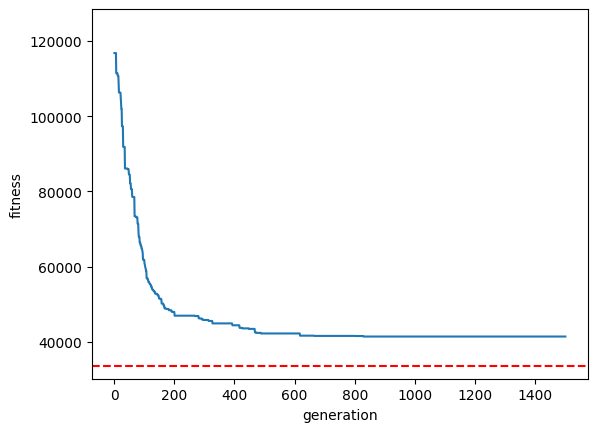

Trail params: {'population_size': 379, 'mutation_rate': 0.5678814428534668, 'elitism_rate': 0.05947953814076695, 'two_children_per_crossover': True}


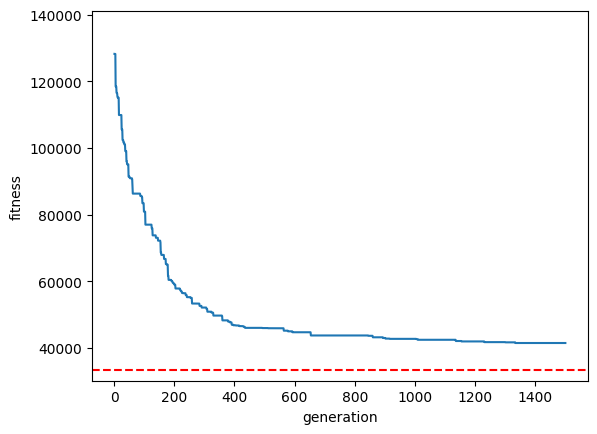

Trail params: {'population_size': 248, 'mutation_rate': 0.9167474061910071, 'elitism_rate': 0.29881212499551235, 'two_children_per_crossover': True}


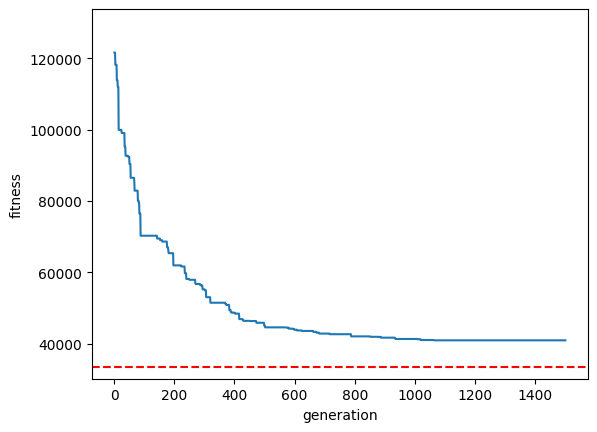

Trail params: {'population_size': 458, 'mutation_rate': 0.42974498877401734, 'elitism_rate': 0.19284917205251417, 'two_children_per_crossover': True}


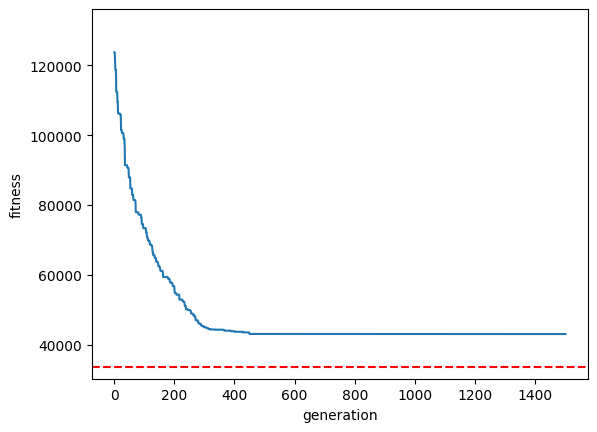

Trail params: {'population_size': 232, 'mutation_rate': 0.6824512494583965, 'elitism_rate': 0.2401914134884189, 'two_children_per_crossover': True}


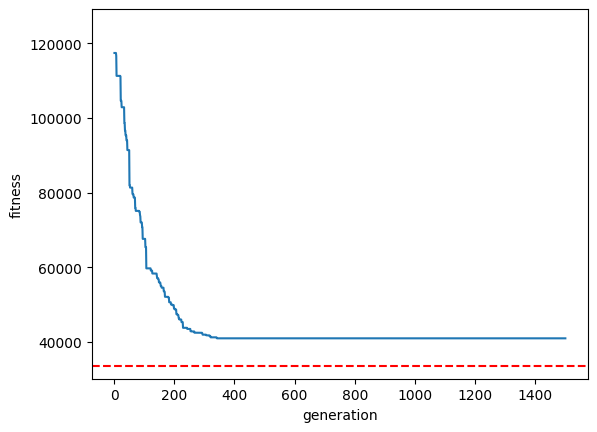

Trail params: {'population_size': 681, 'mutation_rate': 0.22257656032613954, 'elitism_rate': 0.13063474184581028, 'two_children_per_crossover': True}


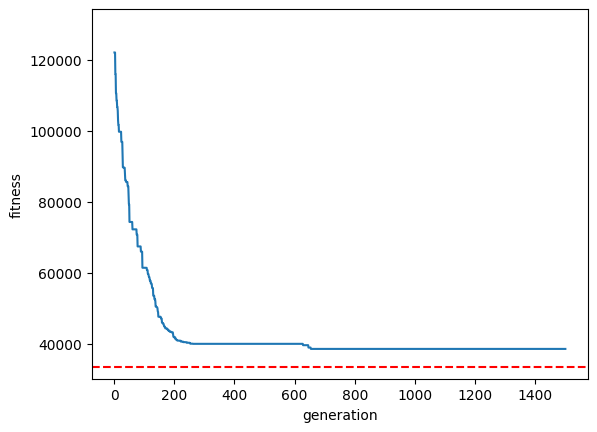

Trail params: {'population_size': 903, 'mutation_rate': 0.8402763215603732, 'elitism_rate': 0.3982003482380819, 'two_children_per_crossover': True}


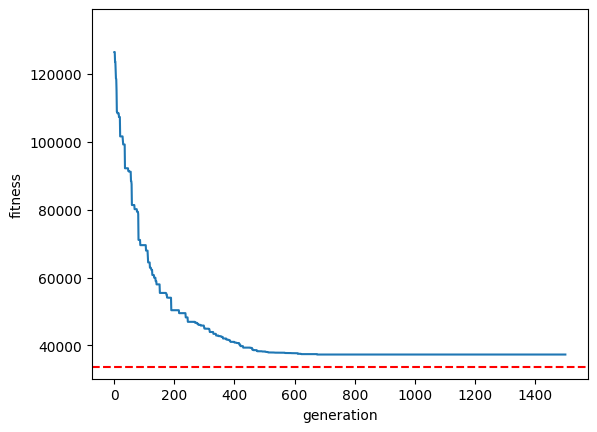

Trail params: {'population_size': 932, 'mutation_rate': 0.865593466553365, 'elitism_rate': 0.42574964552673067, 'two_children_per_crossover': True}


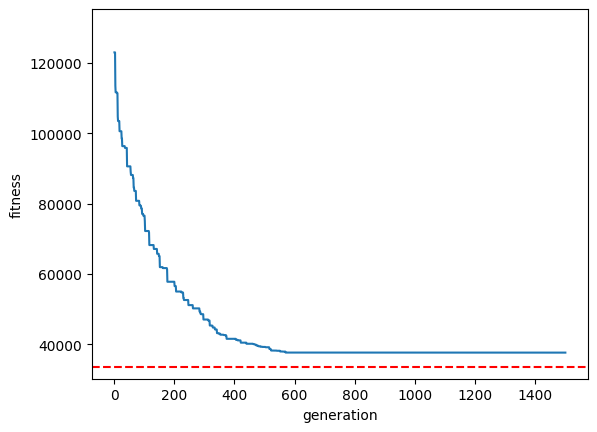

In [5]:
for trail, ga in enumerate(ga_per_trail):
    print(f'Trail params: {study.get_trials()[trail].params}')
    stats_df = ga.fitness_df()
    chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
    plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(optimal_fitness, color='red', linestyle='--')
    plt.show()

# Study Parameters for Ant System

Time Point: 100%|██████████| 700/700 [02:22<00:00,  4.91it/s]


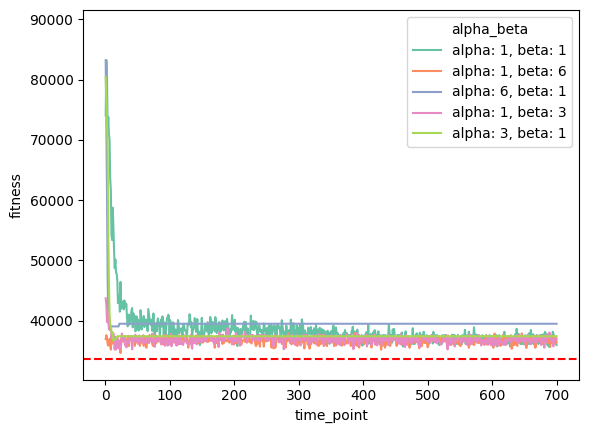

In [86]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
alpha_beta_values = [(1, 1), (1, 6), (6, 1), (1, 3), (3, 1)]
stats_df_list = []
for alpha_beta in alpha_beta_values:
    ant_system = AntSystem(AntTSP, problem_instance, number_of_ants=150, time=700, evaporation_coefficient=0.2, alpha=alpha_beta[0], beta=alpha_beta[1])
    ant_system.run()
    stats_df = ant_system.fitness_df()
    stats_df['alpha_beta'] = f'alpha: {alpha_beta[0]}, beta: {alpha_beta[1]}'
    stats_df_list.append(stats_df)
stats_df_alpha_beta = pd.concat(stats_df_list)
chart = sns.lineplot(data=stats_df_alpha_beta.reset_index(), x='time_point', y='fitness', hue='alpha_beta', palette=sns.color_palette('Set2')[:5])
plt.ylim(optimal_fitness * 0.9, stats_df_alpha_beta.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.legend(title='alpha, beta')
plt.savefig('tsp_as_by_alpha_beta.png')

Time Point: 100%|██████████| 700/700 [02:24<00:00,  4.86it/s]


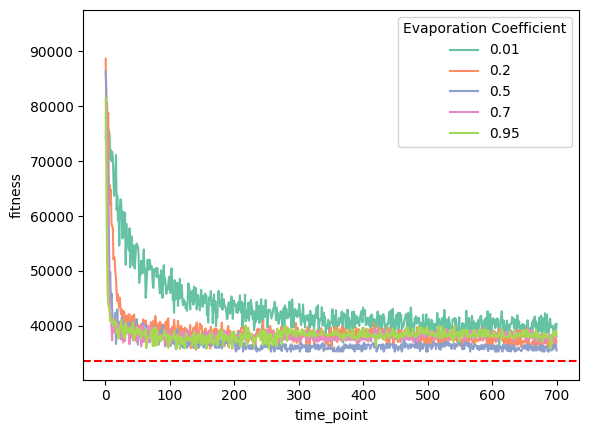

In [2]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
evaporation_coefficient_values = [0.01, 0.2, 0.5, 0.7, 0.95]
stats_df_list = []
for evaporation_coefficient in evaporation_coefficient_values:
    ant_system = AntSystem(AntTSP, problem_instance, number_of_ants=150, time=700, evaporation_coefficient=evaporation_coefficient, alpha=1, beta=1)
    ant_system.run()
    stats_df = ant_system.fitness_df()
    stats_df['evaporation_coefficient'] = evaporation_coefficient
    stats_df_list.append(stats_df)
stats_df_evaporation_coefficient = pd.concat(stats_df_list)
chart = sns.lineplot(data=stats_df_evaporation_coefficient.reset_index(), x='time_point', y='fitness', hue='evaporation_coefficient', palette=sns.color_palette('Set2')[:5])
plt.ylim(optimal_fitness * 0.9, stats_df_evaporation_coefficient.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.legend(title='Evaporation Coefficient')
plt.savefig('tsp_as_by_evaporation_coefficient.png')

In [4]:
PROBLEM_INSTANCE_NAME = 'ATT48'
tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, optimal_fitness = tsp_loader.load_problem_instance()
ant_system_per_trail = []
def objective(trial):
    kwargs = {
        'number_of_ants': trial.suggest_int('number_of_ants', 50, 400),
        'time': 500,
        'visibility': 'distance',
        'trail_update': 'all',
        'alpha': trial.suggest_int('alpha', 1, 6),
        'beta': trial.suggest_int('beta', 1, 6),
        'pheromone_intensity': trial.suggest_int('pheromone_intensity', 1, 8),
        'evaporation_coefficient': trial.suggest_float('evaporation_coefficient', 0.01, 0.9),
    }
    ant_system = AntSystem(AntTSP, problem_instance,**kwargs)
    ant_system.run()
    ant_system_per_trail.append(ant_system)
    return np.min(ant_system.best_fitness_at_time_point)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2022-11-27 20:44:06,787] A new study created in memory with name: no-name-f203bbdd-8b75-423f-bf5a-183ef082709b
Time Point: 100%|██████████| 500/500 [03:12<00:00,  2.60it/s]
[I 2022-11-27 20:47:19,015] Trial 0 finished with value: 34397.0 and parameters: {'number_of_ants': 283, 'alpha': 1, 'beta': 4, 'pheromone_intensity': 5, 'evaporation_coefficient': 0.20445982063420723}. Best is trial 0 with value: 34397.0.
Time Point: 100%|██████████| 500/500 [03:21<00:00,  2.48it/s]
[I 2022-11-27 20:50:40,272] Trial 1 finished with value: 36512.0 and parameters: {'number_of_ants': 297, 'alpha': 4, 'beta': 6, 'pheromone_intensity': 8, 'evaporation_coefficient': 0.3496869059366186}. Best is trial 0 with value: 34397.0.
Time Point: 100%|██████████| 500/500 [03:27<00:00,  2.41it/s]
[I 2022-11-27 20:54:07,624] Trial 2 finished with value: 36333.0 and parameters: {'number_of_ants': 311, 'alpha': 6, 'beta': 4, 'pheromone_intensity': 3, 'evaporation_coefficient': 0.7634156359592058}. Best is trial 0 wit

Trail 0 params: {'number_of_ants': 283, 'alpha': 1, 'beta': 4, 'pheromone_intensity': 5, 'evaporation_coefficient': 0.20445982063420723}


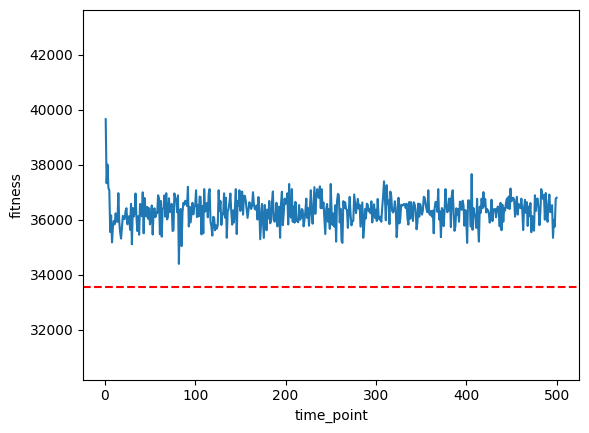

Trail 1 params: {'number_of_ants': 297, 'alpha': 4, 'beta': 6, 'pheromone_intensity': 8, 'evaporation_coefficient': 0.3496869059366186}


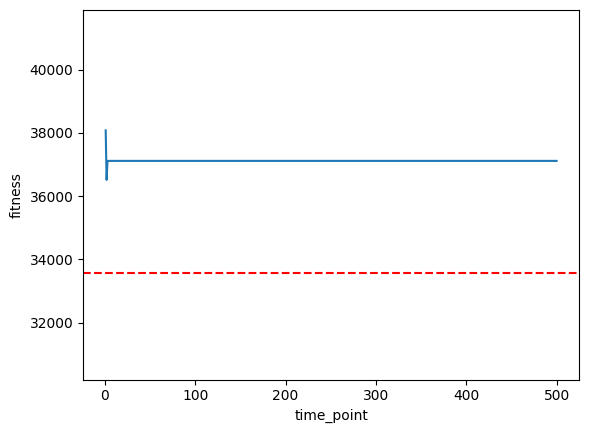

Trail 2 params: {'number_of_ants': 311, 'alpha': 6, 'beta': 4, 'pheromone_intensity': 3, 'evaporation_coefficient': 0.7634156359592058}


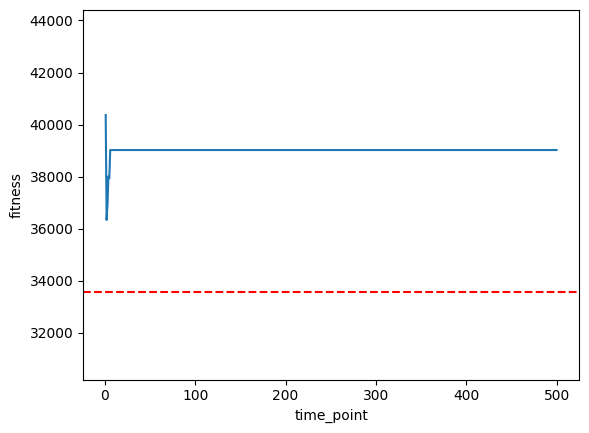

Trail 3 params: {'number_of_ants': 257, 'alpha': 2, 'beta': 4, 'pheromone_intensity': 5, 'evaporation_coefficient': 0.8036790687153887}


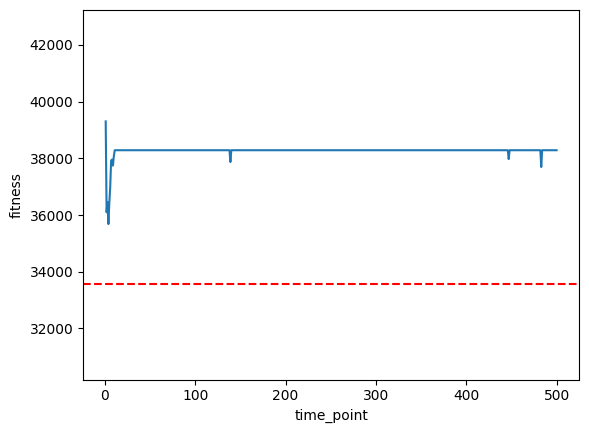

Trail 4 params: {'number_of_ants': 292, 'alpha': 1, 'beta': 6, 'pheromone_intensity': 7, 'evaporation_coefficient': 0.08870331208934992}


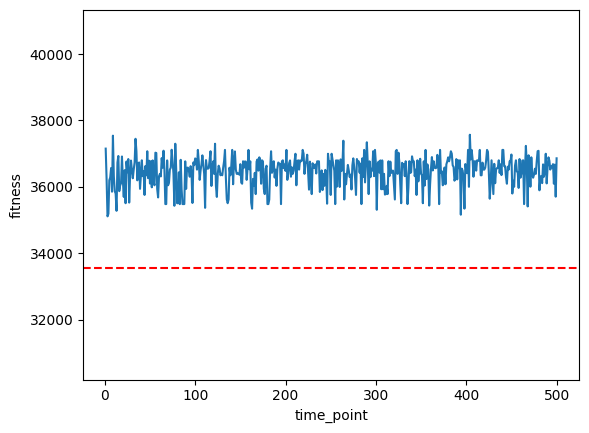

Trail 5 params: {'number_of_ants': 255, 'alpha': 3, 'beta': 4, 'pheromone_intensity': 5, 'evaporation_coefficient': 0.20268867795392373}


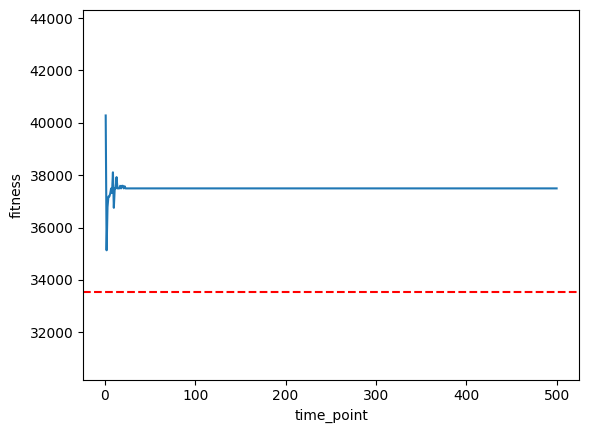

Trail 6 params: {'number_of_ants': 375, 'alpha': 4, 'beta': 1, 'pheromone_intensity': 1, 'evaporation_coefficient': 0.8849822636148419}


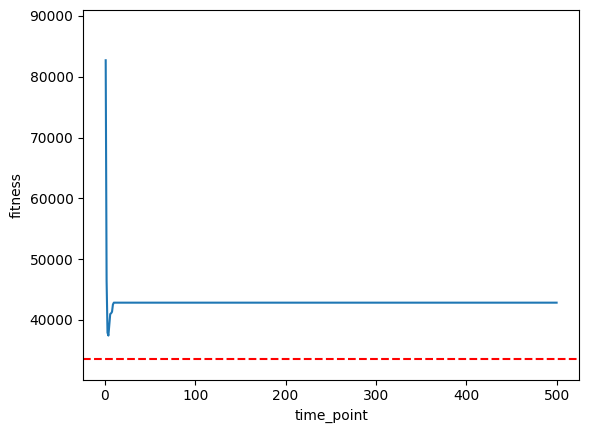

Trail 7 params: {'number_of_ants': 287, 'alpha': 2, 'beta': 1, 'pheromone_intensity': 1, 'evaporation_coefficient': 0.3808837220964155}


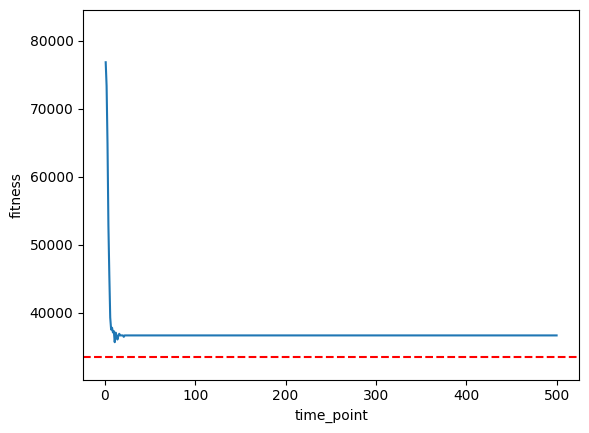

Trail 8 params: {'number_of_ants': 85, 'alpha': 5, 'beta': 4, 'pheromone_intensity': 2, 'evaporation_coefficient': 0.5919429377162552}


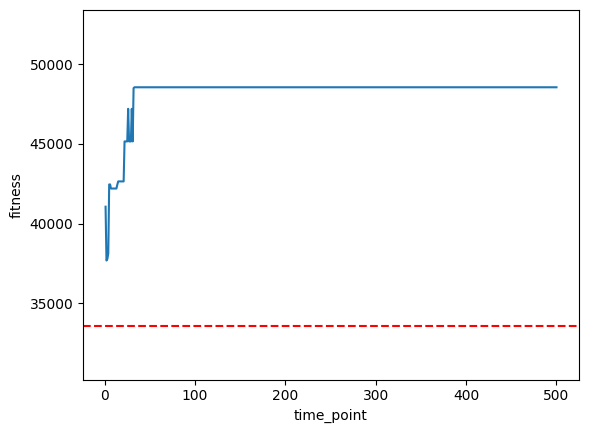

Trail 9 params: {'number_of_ants': 179, 'alpha': 6, 'beta': 3, 'pheromone_intensity': 2, 'evaporation_coefficient': 0.8690695729925486}


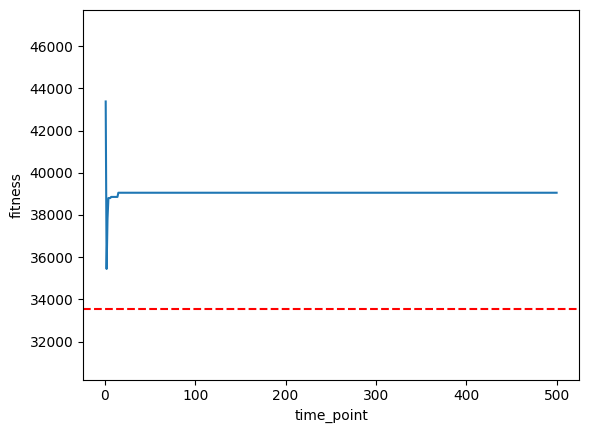

Trail 10 params: {'number_of_ants': 171, 'alpha': 1, 'beta': 2, 'pheromone_intensity': 6, 'evaporation_coefficient': 0.0342047016959334}


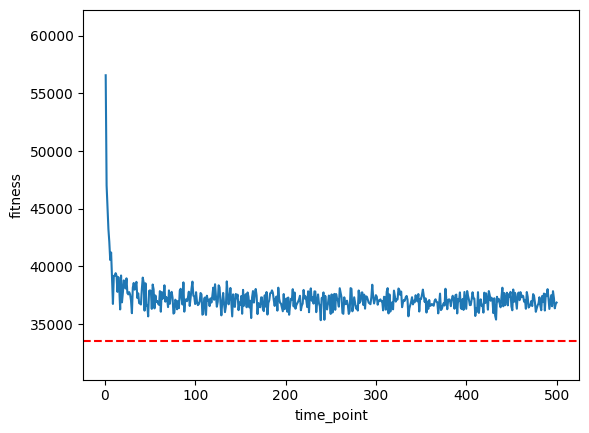

Trail 11 params: {'number_of_ants': 381, 'alpha': 1, 'beta': 6, 'pheromone_intensity': 7, 'evaporation_coefficient': 0.011850984434274944}


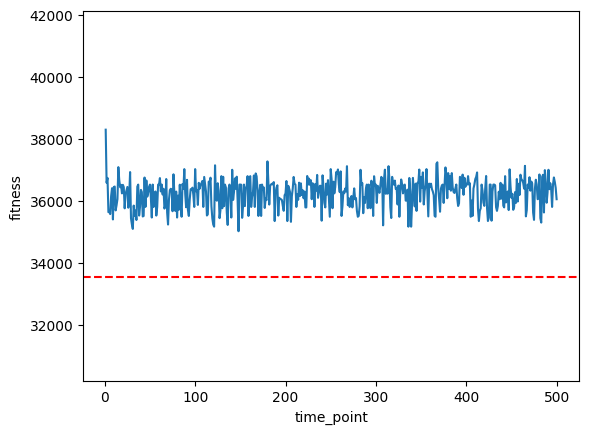

Trail 12 params: {'number_of_ants': 392, 'alpha': 2, 'beta': 5, 'pheromone_intensity': 7, 'evaporation_coefficient': 0.22311020628114936}


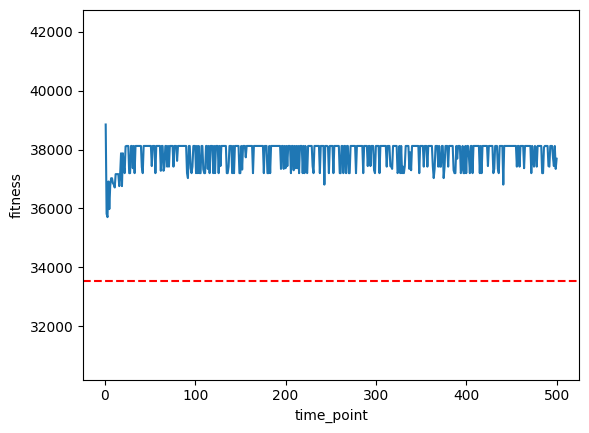

Trail 13 params: {'number_of_ants': 355, 'alpha': 1, 'beta': 5, 'pheromone_intensity': 4, 'evaporation_coefficient': 0.17604268434779602}


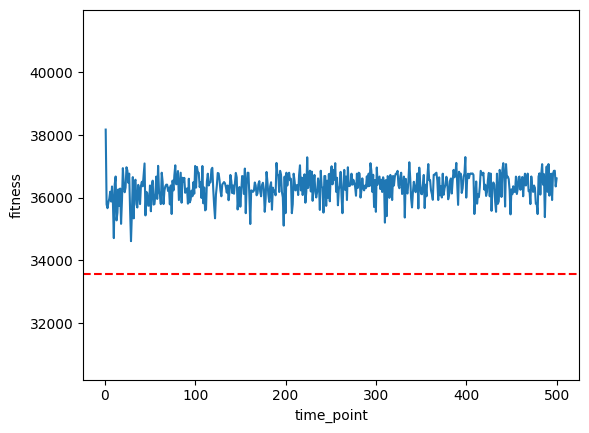

Trail 14 params: {'number_of_ants': 340, 'alpha': 3, 'beta': 5, 'pheromone_intensity': 4, 'evaporation_coefficient': 0.23550884368664388}


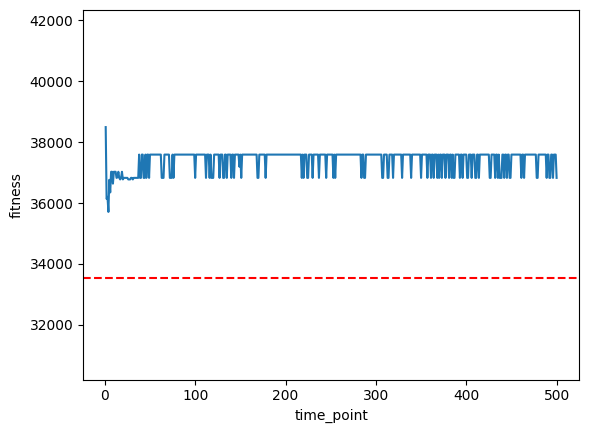

Trail 15 params: {'number_of_ants': 201, 'alpha': 1, 'beta': 3, 'pheromone_intensity': 4, 'evaporation_coefficient': 0.5280408350323553}


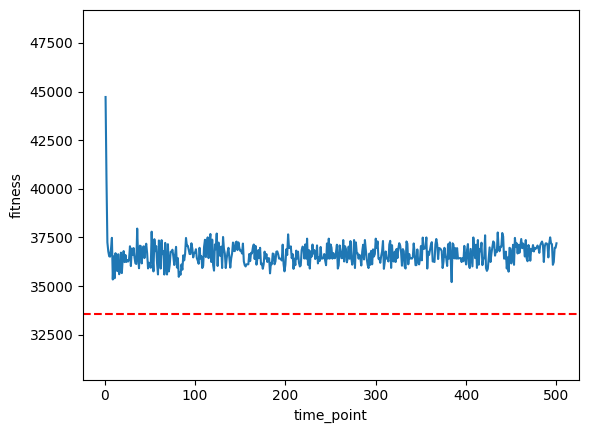

Trail 16 params: {'number_of_ants': 335, 'alpha': 2, 'beta': 5, 'pheromone_intensity': 3, 'evaporation_coefficient': 0.14772486316360697}


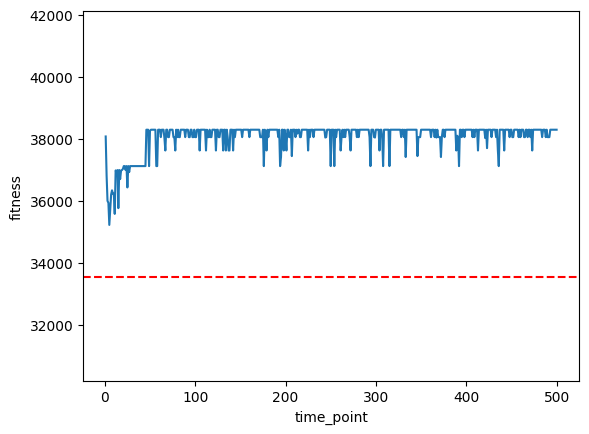

Trail 17 params: {'number_of_ants': 124, 'alpha': 3, 'beta': 5, 'pheromone_intensity': 6, 'evaporation_coefficient': 0.31246242852169576}


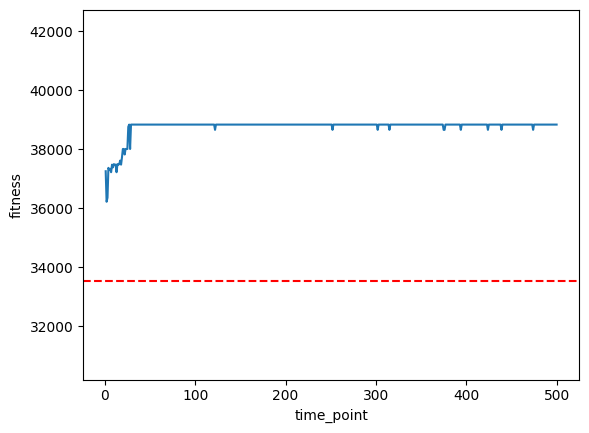

Trail 18 params: {'number_of_ants': 237, 'alpha': 1, 'beta': 3, 'pheromone_intensity': 3, 'evaporation_coefficient': 0.46466805318791804}


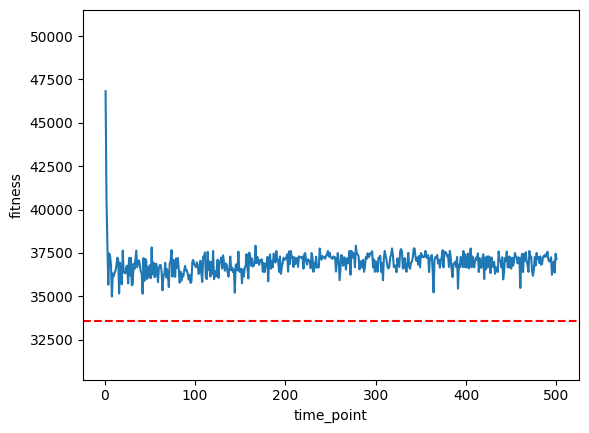

Trail 19 params: {'number_of_ants': 358, 'alpha': 2, 'beta': 2, 'pheromone_intensity': 5, 'evaporation_coefficient': 0.6301905553406317}


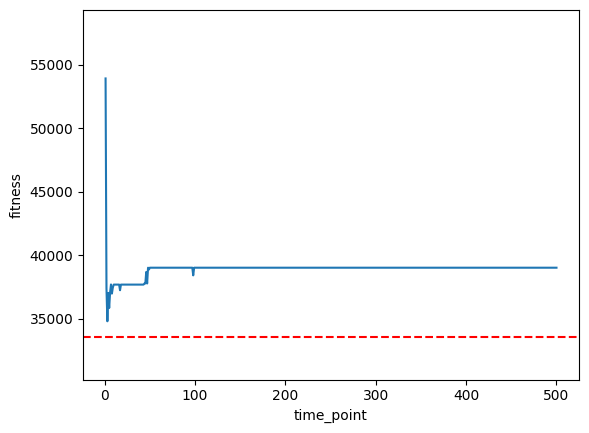

In [5]:
for trail, ant_system in enumerate(ant_system_per_trail):
    print(f'Trail {trail} params: {study.get_trials()[trail].params}')
    stats_df = ant_system.fitness_df()
    chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
    plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(optimal_fitness, color='red', linestyle='--')
    plt.show()